In [5]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# SVD applications

- Data compression/PCA
- Total least squares (TLS)


Data often come in the form of a matrix (spreadsheet) or can be reshaped into that form.

The SVD is
$$ A = \sum_{i=1}^r \sigma_i u_i v_i^T $$ 

and a rank-$k$ approximation is
$$ A_k = \sum_{i=1}^k \sigma_i u_i v_i^T $$ 

# Example:   Image compression 
(stolen from APMA 4300 and matlab)

How does this work in practice?

## The original Matrix (From Durer's Melancholia)

<img align=center src="Durer_Melancholia_I.jpg" width=600>

In [6]:
from matplotlib import image
data = image.imread('melancholia-magic-square.png')
m,n = data.shape

453x457 pixel image


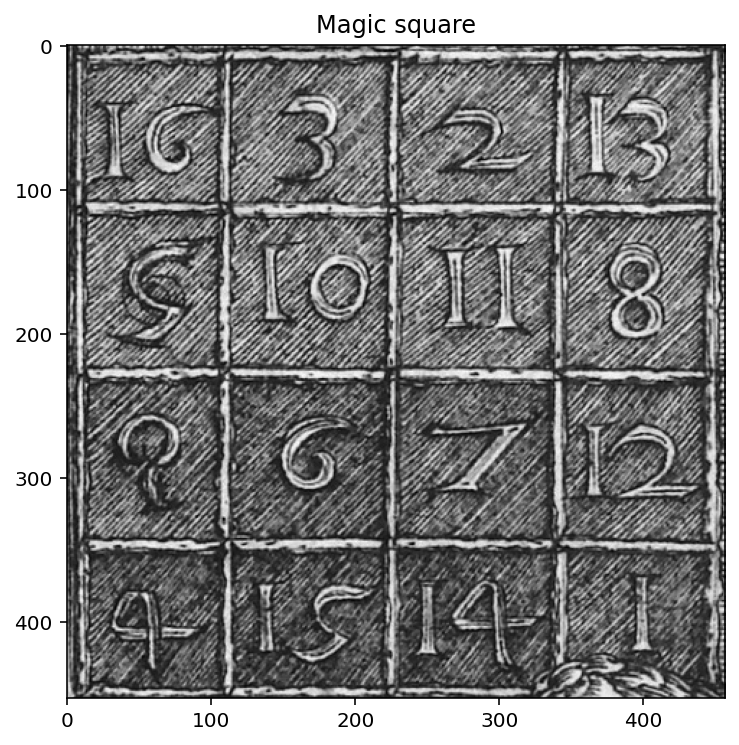

In [7]:
print('{}x{} pixel image'.format(m,n))
plt.figure(figsize=(8,6))
plt.imshow(data,cmap='gray')
plt.title('Magic square')
plt.show()

In [8]:
u, s, vt = np.linalg.svd(data)

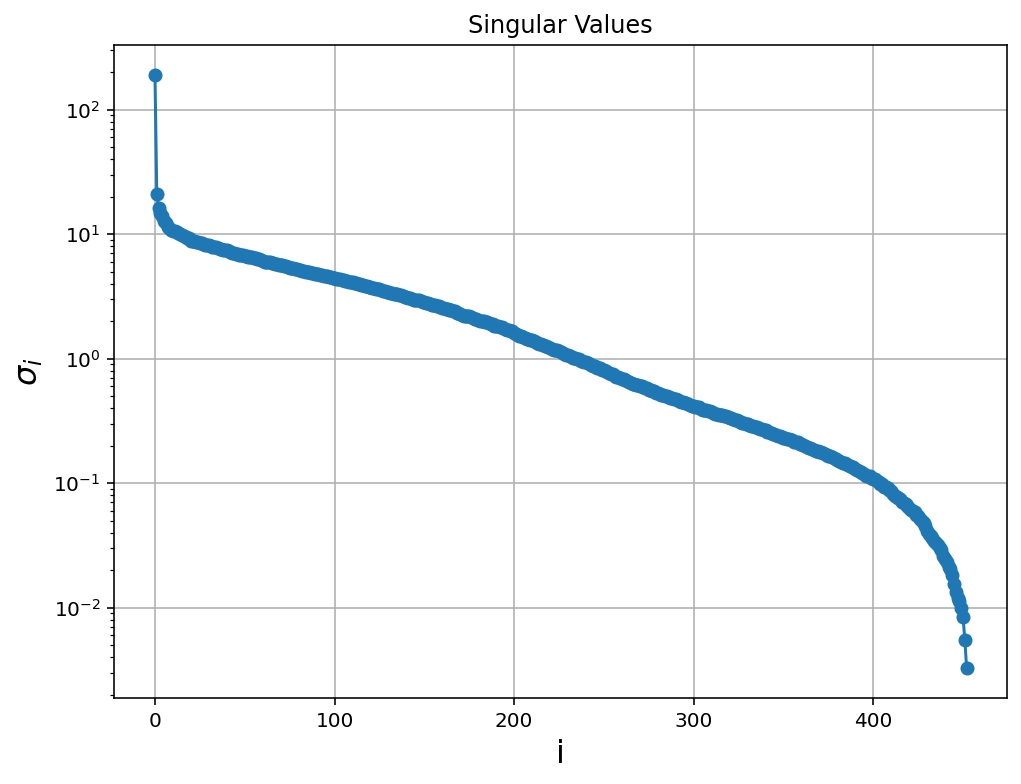

In [9]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.semilogy(s,'o-')
axes.set_ylabel('$\sigma_i$', fontsize=16)
axes.set_xlabel('i', fontsize=16)
axes.grid()
axes.set_title('Singular Values')
plt.show()

## First 4 Modes

where mode $i$ is the rank-1 matrix $\sigma_i\mathbf{u}_i\mathbf{v}_i^T$

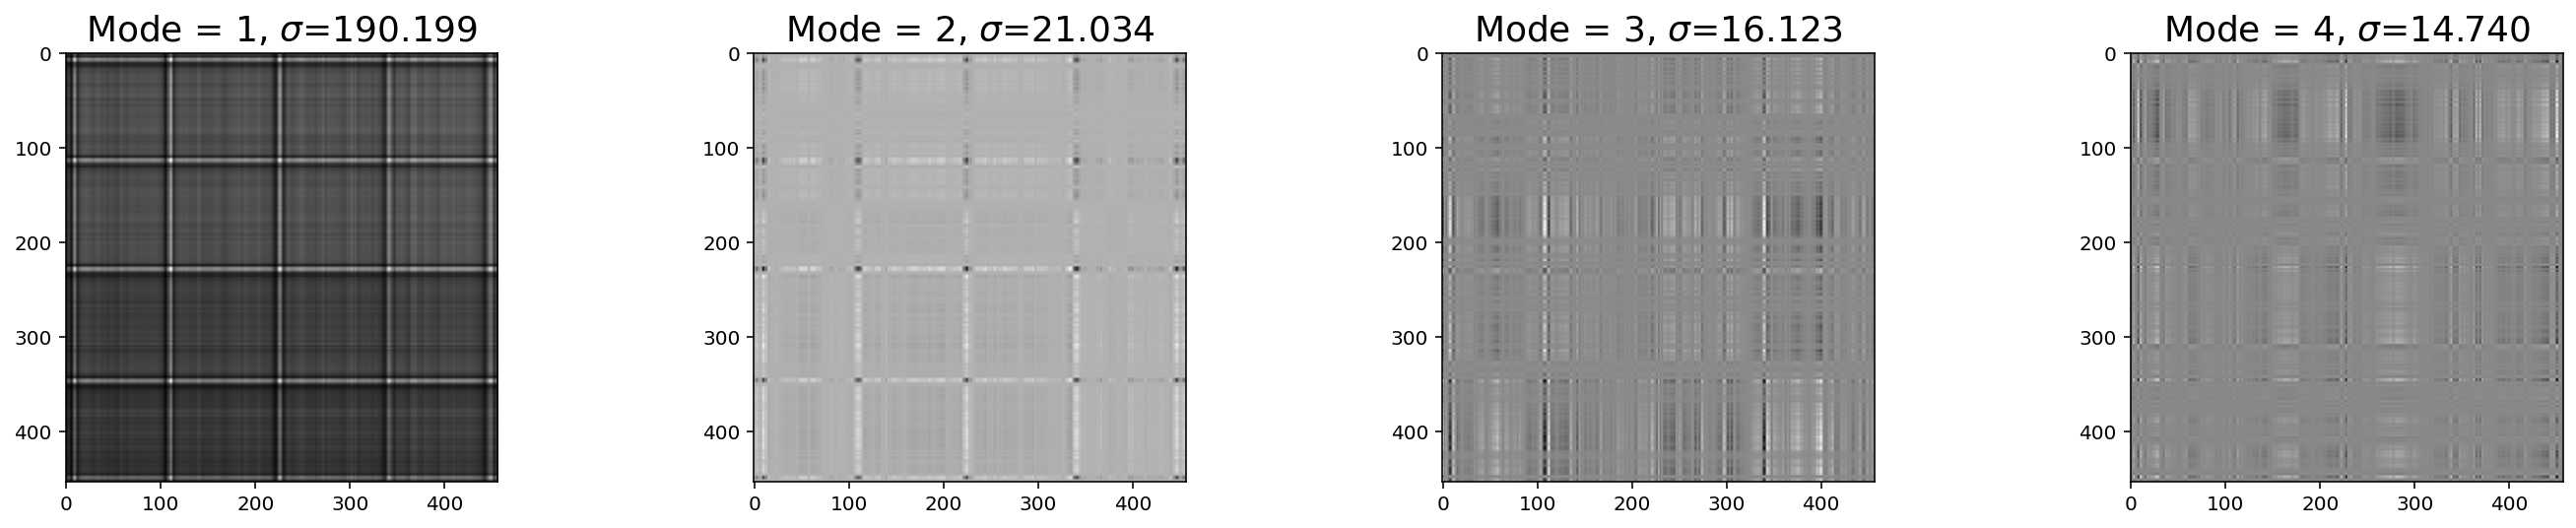

In [10]:
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 4)
fig.set_figheight(fig.get_figheight() * 1)
for i in range(4):
    mode = s[i]*np.outer(u[:,i], vt[i,:])

    axes = fig.add_subplot(1, 4, i+1)
    mappable = axes.imshow(mode, cmap='gray')
    axes.set_title('Mode = {}, $\sigma$={:3.3f}'.format(i+1,s[i]),fontsize=18)
    
plt.show()

## Compressed Reconstructions

We can now view compressed reconstructions that sum the first $k$ modes
$$
    A_k = \sum_{i=1}^k \sigma_i\mathbf{u}_i\mathbf{v}_i^T = U_k\Sigma_kV_k^T
$$

the amount of memory required to store $A_k$ is $O(k(m +n + 1))$ whereas the storage of $A$ is $O(mn)$ so the relative compression is

$$
    \frac{k(m+n + 1)}{mn}
$$

The question is how many modes are required to adequately reconstruct the original image?
    

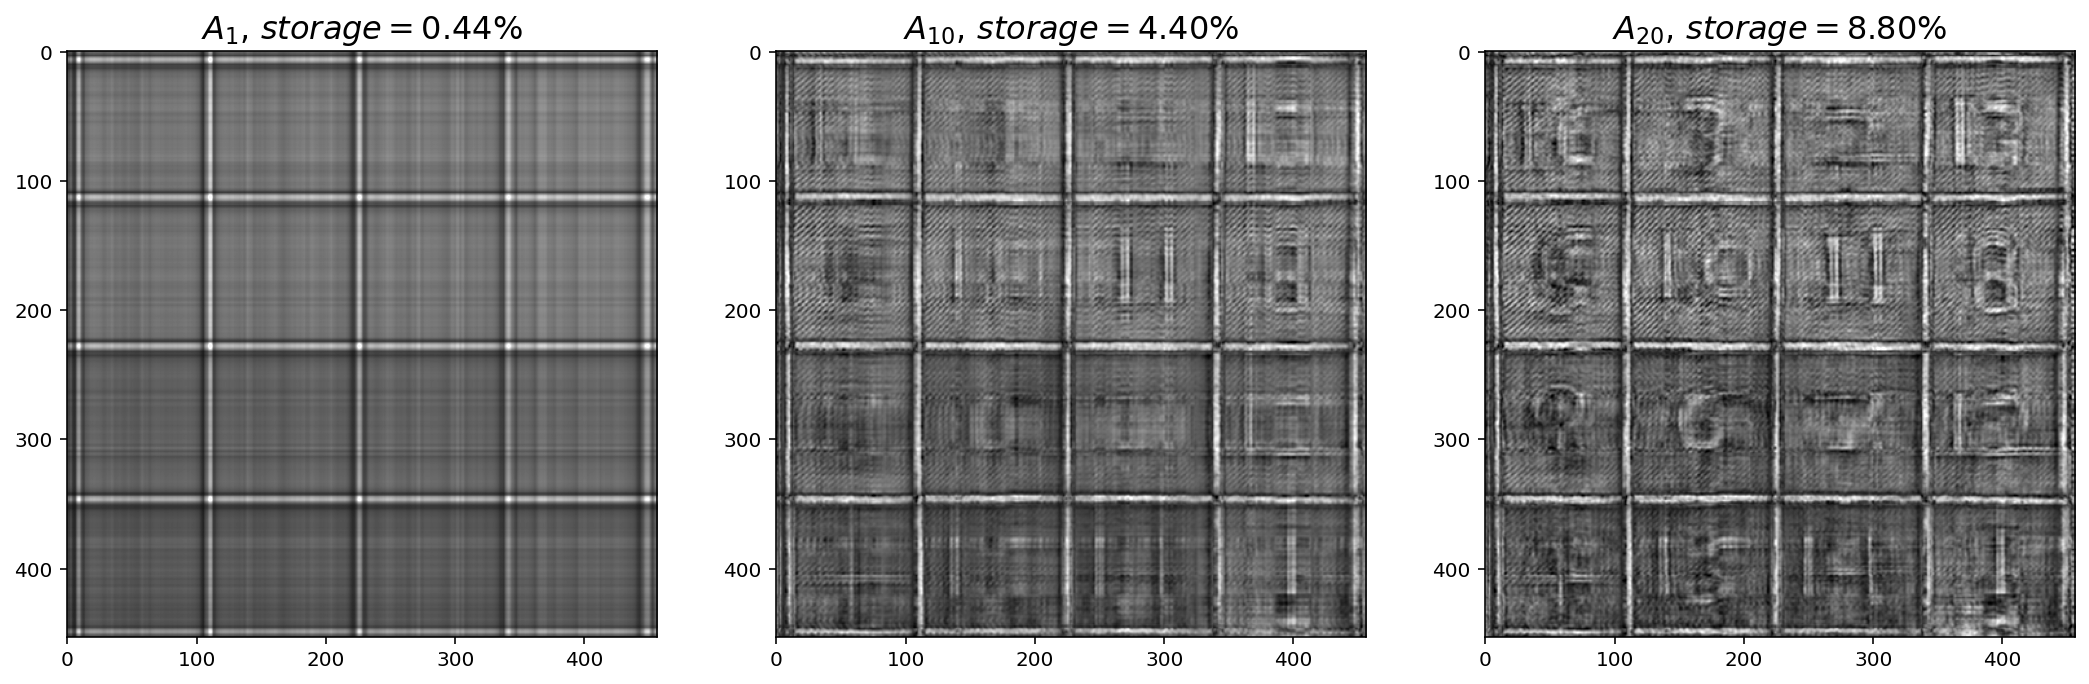

In [11]:
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 3)
fig.set_figheight(fig.get_figheight() *2)
for i,k in enumerate([1, 10, 20]):
    Ak = u[:,:k].dot(np.diag(s[:k]).dot(vt[:k,:]))
    storage = 100.*k*(m+n + 1)/(m*n)
    axes = fig.add_subplot(1, 3, i+1)
    mappable = axes.imshow(Ak, vmin=0.0, vmax=1.0, cmap='gray')
    axes.set_title('$A_{{{}}}$, $storage={:2.2f}\%$'.format(k,storage),fontsize=16)
    
plt.show()

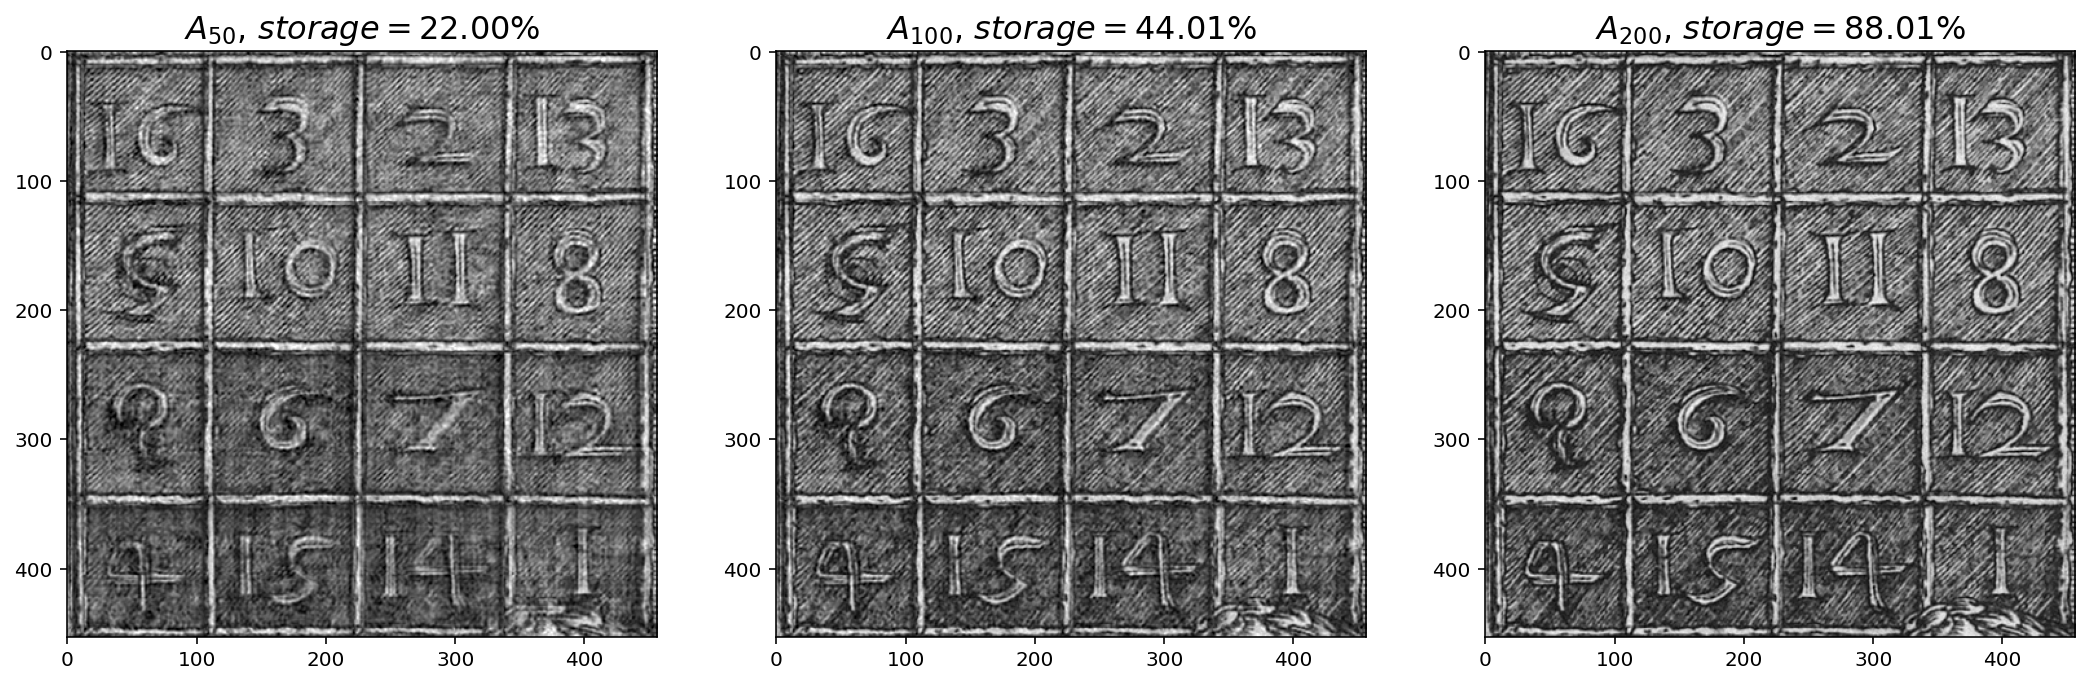

In [12]:
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 3)
fig.set_figheight(fig.get_figheight() *2)
for i,k in enumerate([50, 100, 200]):
    Ak = u[:,:k].dot(np.diag(s[:k]).dot(vt[:k,:]))
    storage = 100.*k*(m+n + 1)/(m*n)
    axes = fig.add_subplot(1, 3, i+1)
    mappable = axes.imshow(Ak, vmin=0.0, vmax=1.0, cmap='gray')
    axes.set_title('$A_{{{}}}$, $storage={:2.2f}\%$'.format(k,storage),fontsize=16)
    
plt.show()

# Example: Principal components analysis

Similar to the above example, except
- data are a sequence of images
    - some reshaping required
- the time average is removed from the data
- there are a statistical interpretations
    - e.g., orthogonal = uncorrelated

## Read sea surface temperature (SST) data

In [13]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [14]:
# Construct the url pointing to the data
dl_loc = 'SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/'
region_str = 'Y/-30/30/RANGE/'
time_str = 'T/(Jan%201950)/(Dec%202020)/RANGE/T/(Dec)/VALUES/'
time_fix = 'T/(days%20since%201960-01-01)streamgridunitconvert/'
sst_url = 'https://iridl.ldeo.columbia.edu/' + dl_loc + time_str + region_str + 'zlev/removeGRID/' + time_fix + 'dods'
sst_url

'https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/T/(Jan%201950)/(Dec%202020)/RANGE/T/(Dec)/VALUES/Y/-30/30/RANGE/zlev/removeGRID/T/(days%20since%201960-01-01)streamgridunitconvert/dods'

In [15]:
# Open the dataset
sst_ds = xr.open_dataset(sst_url)
sst_ds

<xarray.Dataset>
Dimensions:  (T: 71, X: 180, Y: 31)
Coordinates:
  * X        (X) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * Y        (Y) float32 -30.0 -28.0 -26.0 -24.0 -22.0 ... 24.0 26.0 28.0 30.0
  * T        (T) datetime64[ns] 1950-12-15T12:00:00 ... 2020-12-15T12:00:00
Data variables:
    sst      (T, Y, X) float32 ...
Attributes:
    Conventions:  IRIDL

## Plot some of it

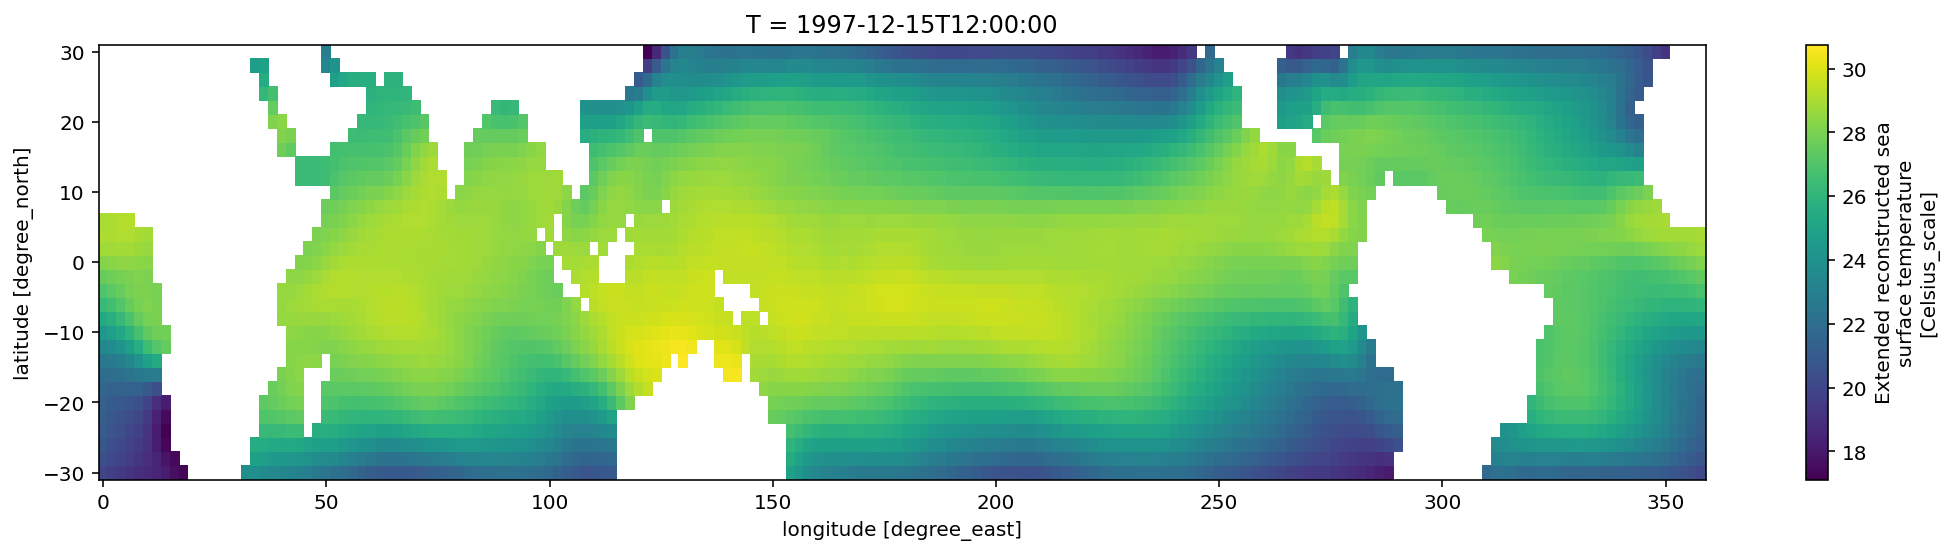

In [16]:
# Plot a value
sst_ds.sst.sel(T='1997').plot(figsize=(18, 4));

What do you see? Is it unusual?

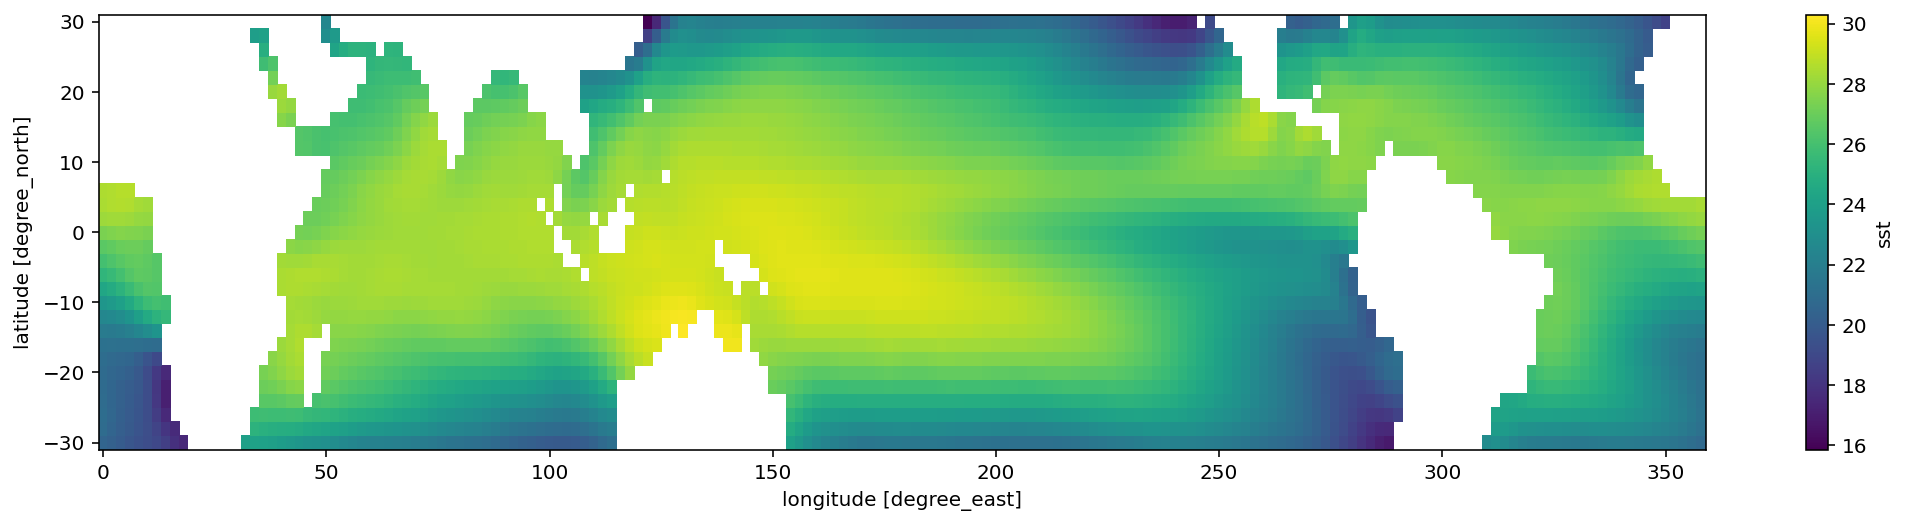

In [17]:
# Plot the average (mean)
sst_ds.sst.mean('T').plot(figsize=(18, 4));

## Remove the mean

In [18]:
# Remove the mean. What's left is "anomalous"
ssta = sst_ds.sst - sst_ds.sst.mean('T')

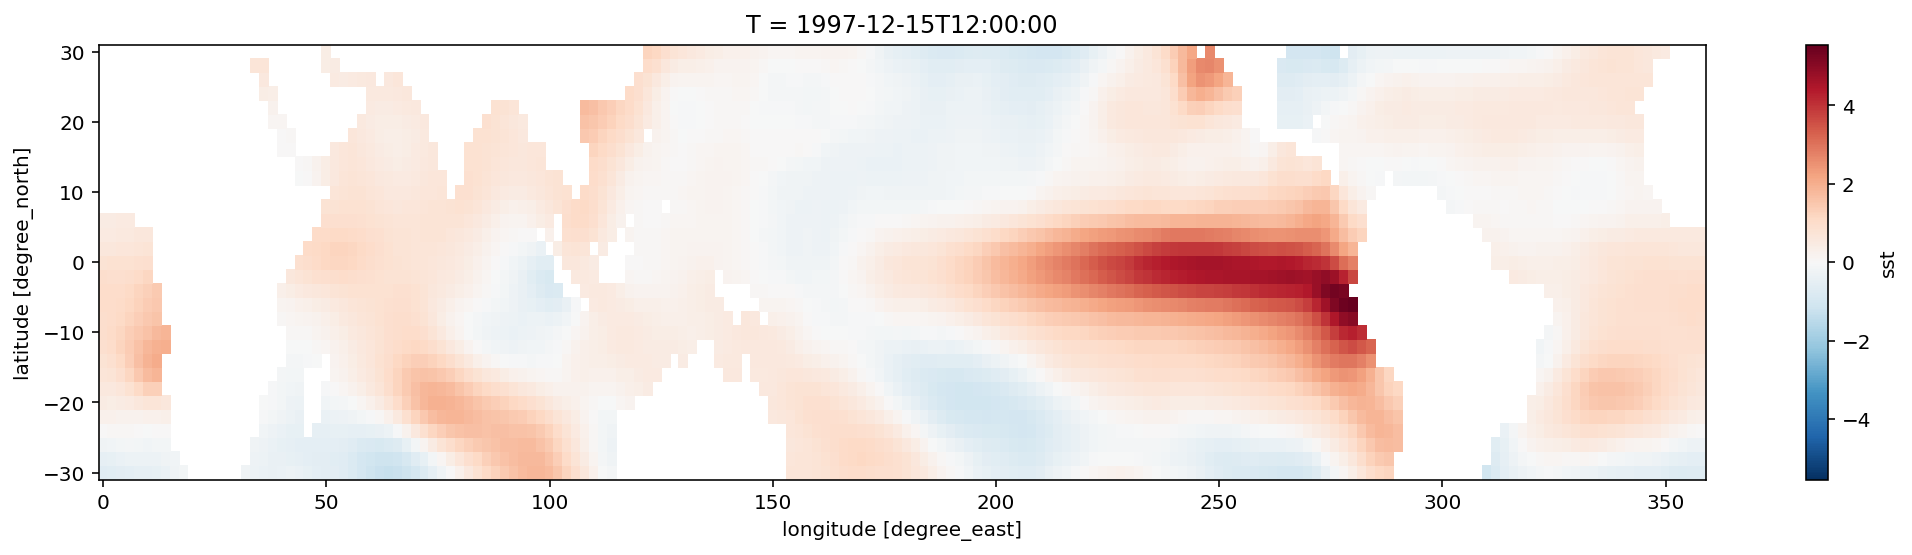

In [19]:
# Plot a value
ssta.sel(T='1997').plot(figsize=(18, 4));

What do you see? Is it unusual?

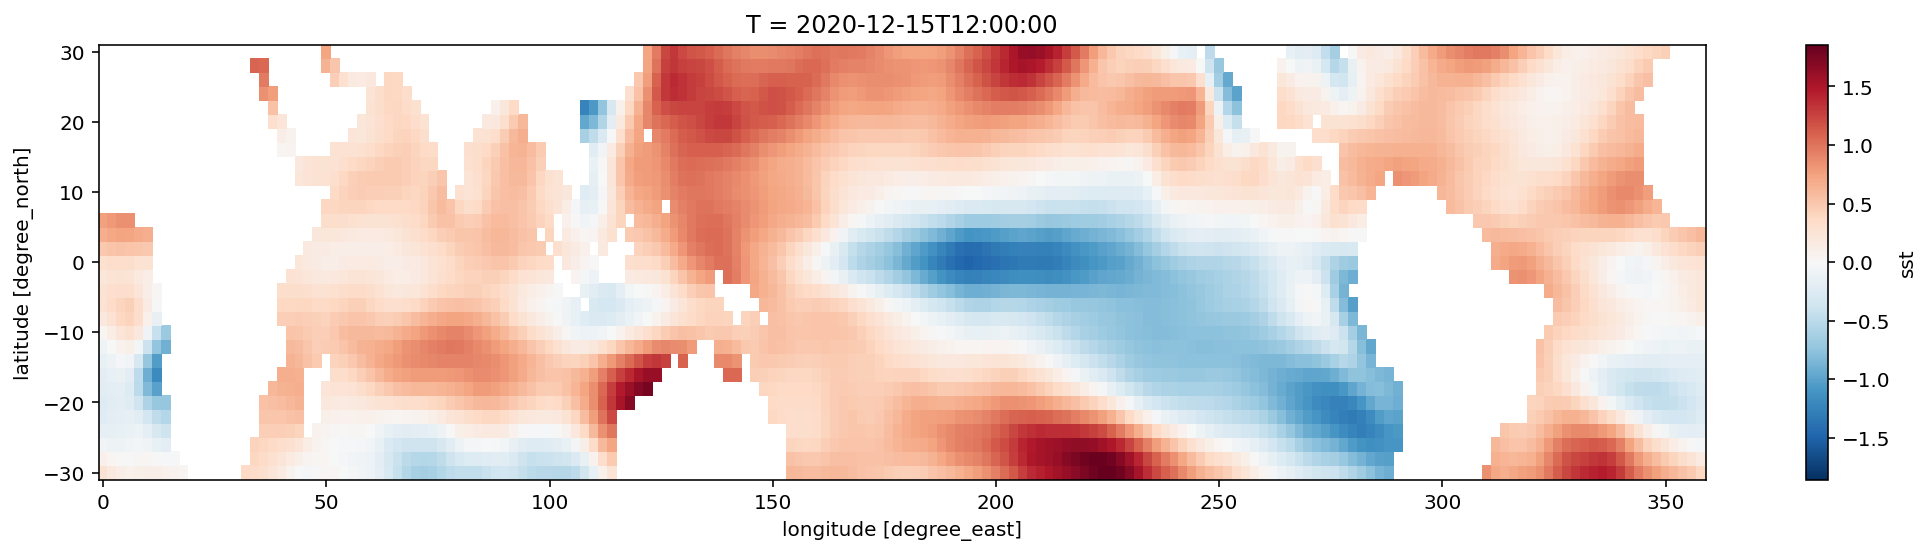

In [20]:
# Plot a value
ssta.sel(T='2020').plot(figsize=(18, 4));

## Multi-dimensional data to 2D

### Stack

"Stack any number of existing dimensions into a single new dimension."

http://xarray.pydata.org/en/stable/generated/xarray.DataArray.stack.html

In [21]:
ssta2D = ssta.stack(YX=('Y', 'X'))
ssta2D

<xarray.DataArray 'sst' (T: 71, YX: 5580)>
array([[-1.1821136 , -1.2122517 , -1.2322006 , ...,         nan,
                nan,         nan],
       [ 0.02244186,  0.04620934, -0.03631592, ...,         nan,
                nan,         nan],
       [-0.6492691 , -0.6941395 , -0.7121563 , ...,         nan,
                nan,         nan],
       ...,
       [ 0.6034241 ,  0.61644554,  0.600996  , ...,         nan,
                nan,         nan],
       [ 0.00934792,  0.08796501,  0.14690018, ...,         nan,
                nan,         nan],
       [ 0.27025795,  0.1757927 ,  0.117836  , ...,         nan,
                nan,         nan]], dtype=float32)
Coordinates:
  * T        (T) datetime64[ns] 1950-12-15T12:00:00 ... 2020-12-15T12:00:00
  * YX       (YX) MultiIndex
  - Y        (YX) float64 -30.0 -30.0 -30.0 -30.0 -30.0 ... 30.0 30.0 30.0 30.0
  - X        (YX) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0

In [22]:
ssta2D.shape

(71, 5580)

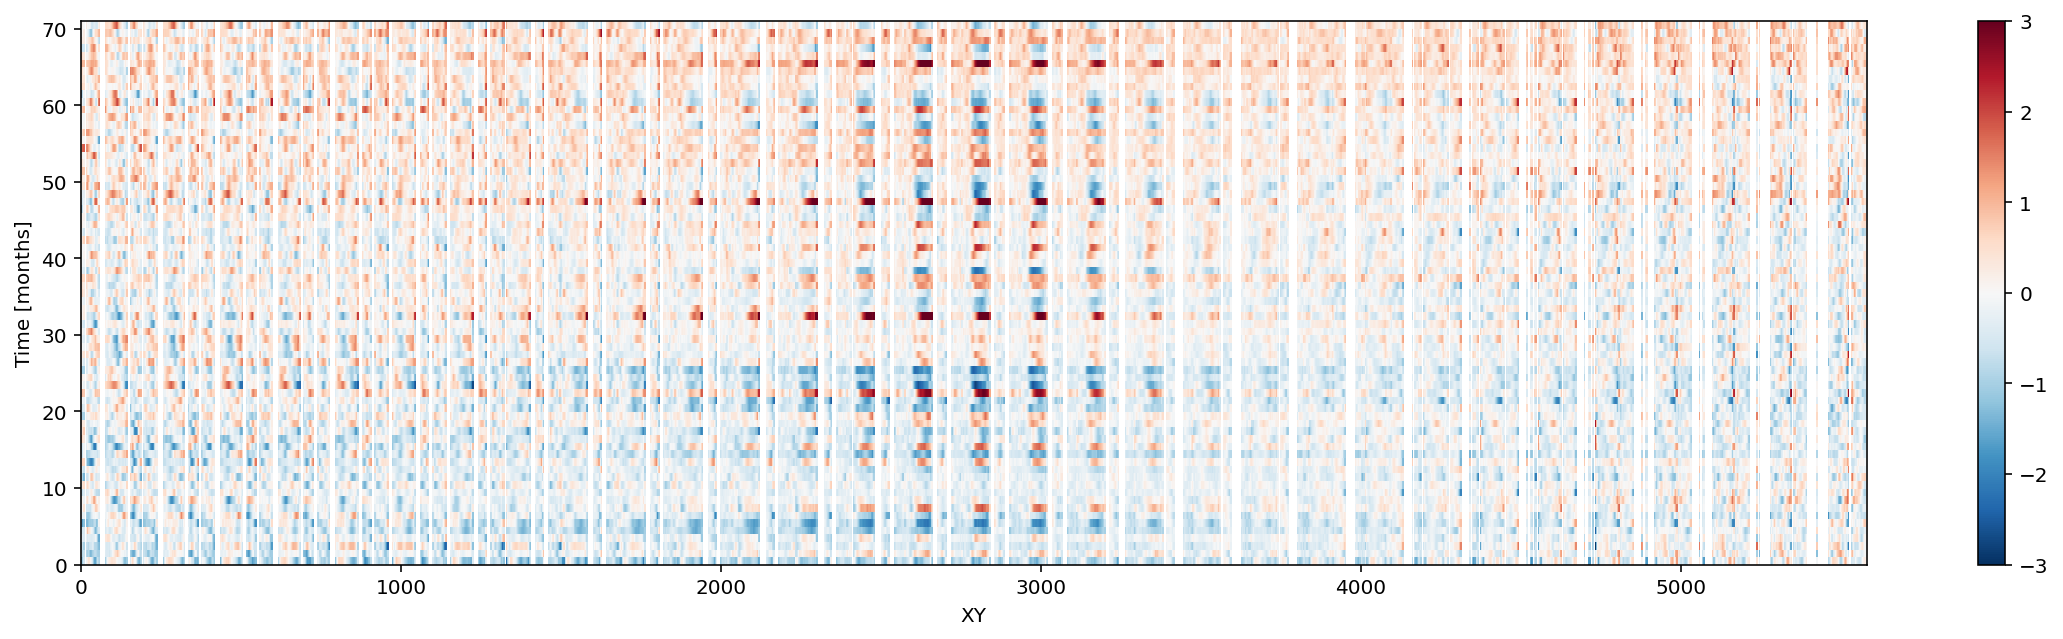

In [23]:
fig, ax = plt.subplots(figsize = (20, 5))
g = ax.pcolormesh(ssta2D, cmap='RdBu_r', vmin=-3, vmax=3);
ax.set_xlabel('XY')
ax.set_ylabel('Time [months]')
plt.colorbar(g);

In [24]:
goodXY = ~np.isnan(ssta2D[0,:])

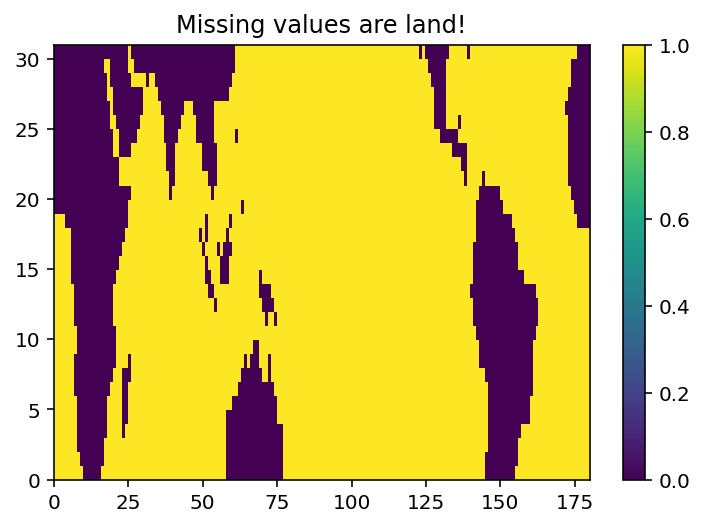

In [25]:
nt, ny, nx = ssta.shape
plt.pcolormesh(goodXY.values.reshape(ny, nx));
plt.title('Missing values are land!')
plt.colorbar();

Create a matrix that only has the non-missing values. `.values` makes the xarray DataArray into a numpy array. 

In [26]:
dta = ssta2D.values[:,goodXY]
nt, nl = dta.shape

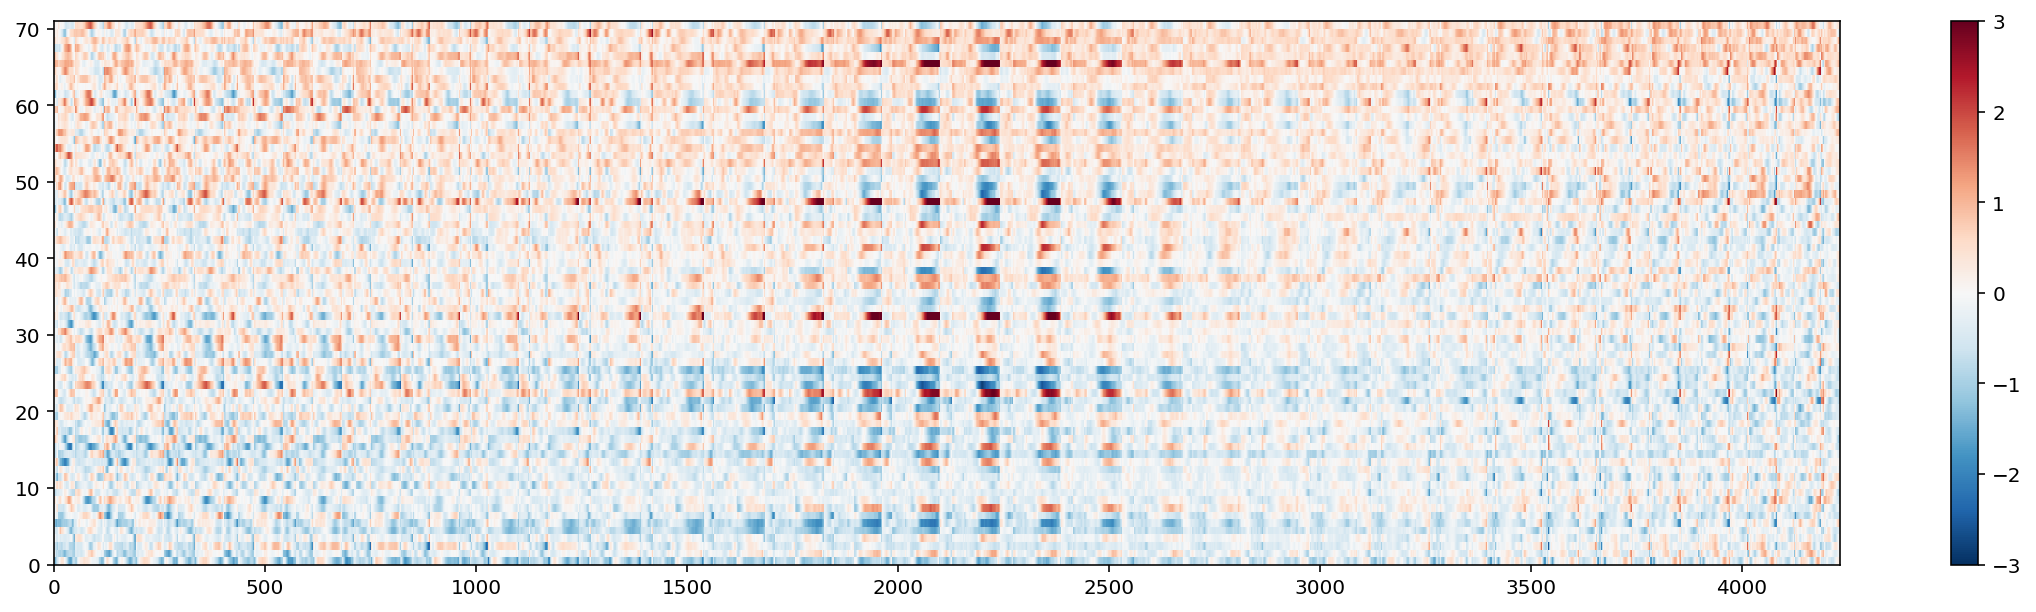

In [27]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.pcolormesh(dta, cmap='RdBu_r', vmin=-3, vmax=3);
plt.colorbar();

In theory, one can have time vary along rows or columns. In practice, it is less confusing to choose a data model and stick with it. 

My mental image is that every column is a different time, which means that each row is *time series*, and we plot time series horizontally, like rows. Therefore, we take the transpose of `dta`.

## A matrix

/Users/tippett/miniconda3/envs/pangeo2/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """


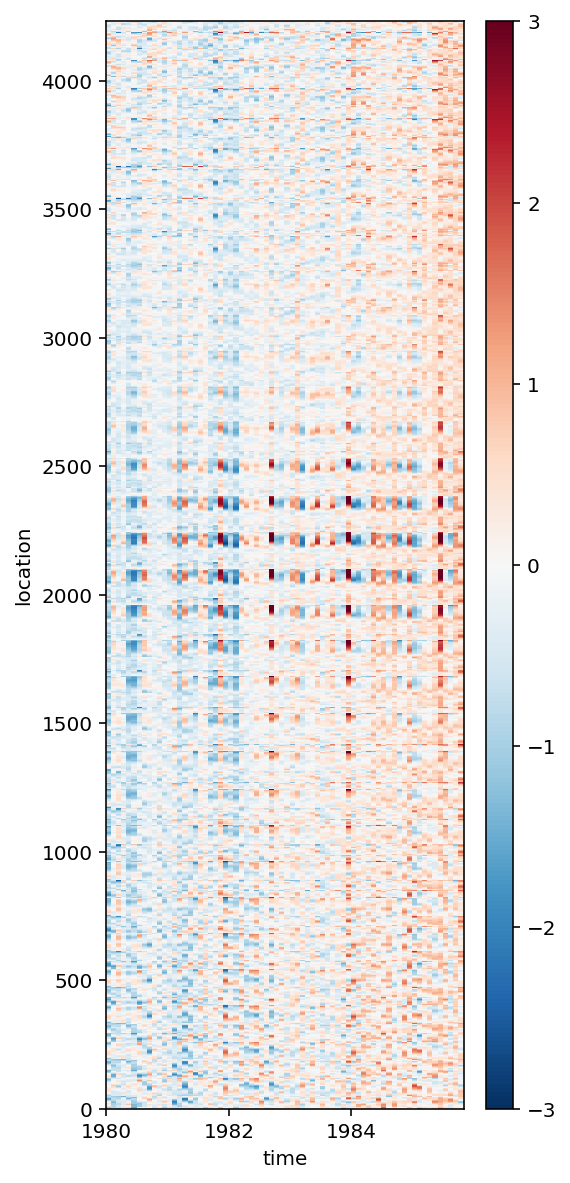

In [28]:
A = dta.T
time = np.arange(nt)/12 + 1980

fig, ax = plt.subplots(figsize=(4, 10))
g = ax.pcolormesh(time, np.arange(nl), A, cmap='RdBu_r', vmin=-3, vmax=3);
ax.set_xlabel('time')
ax.set_ylabel('location')
plt.colorbar(g, fraction = 0.15, aspect = 40);

In [29]:
# SVD
from scipy import linalg
U, S, Vt = linalg.svd(A, full_matrices=False)
V = Vt.T

# save for later
S1 = S

In [30]:
# Some sanity checks
# economy
print(U.shape)
print(V.shape)
print(S.shape)

(4231, 71)
(71, 71)
(71,)


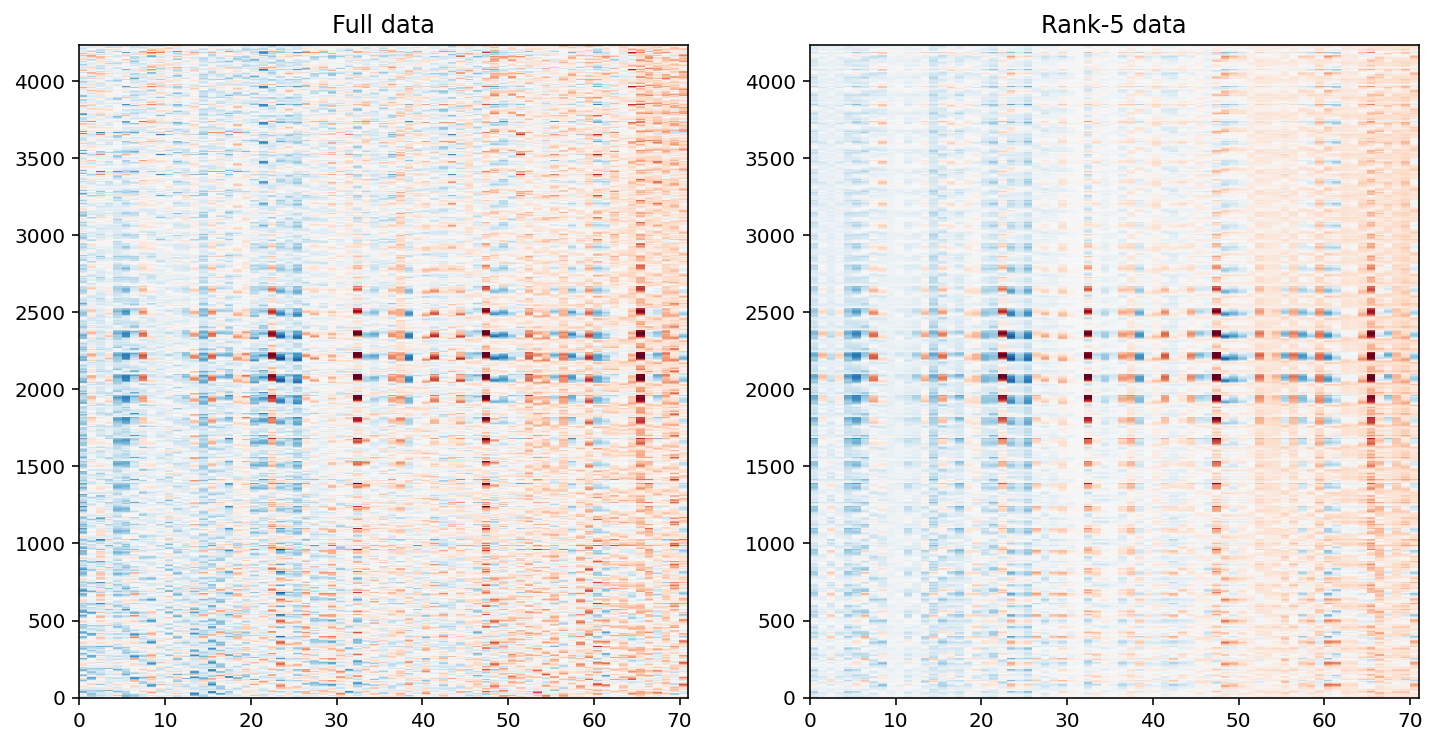

In [31]:
fig, axs = plt.subplots(1, 2, figsize = (12, 6))

# A = USV^T
Asvd = U @ np.diag(S) @ V.T
ax = axs[0]
ax.pcolormesh(Asvd, cmap='RdBu_r', vmin=-3, vmax=3)
ax.set_title('Full data')

# A = USV^T rank-k approximation
k = 5
A_approx = U[:, :k] @ np.diag(S[:k]) @ V[:,:k].T
ax = axs[1]
ax.pcolormesh(A_approx, cmap='RdBu_r', vmin=-3, vmax=3);
ax.set_title('Rank-5 data');

In [32]:
ssta2D_approx = ssta2D.copy()
ssta2D_approx.values[:,goodXY] = A_approx.T
ssta_approx = ssta2D_approx.unstack('YX')

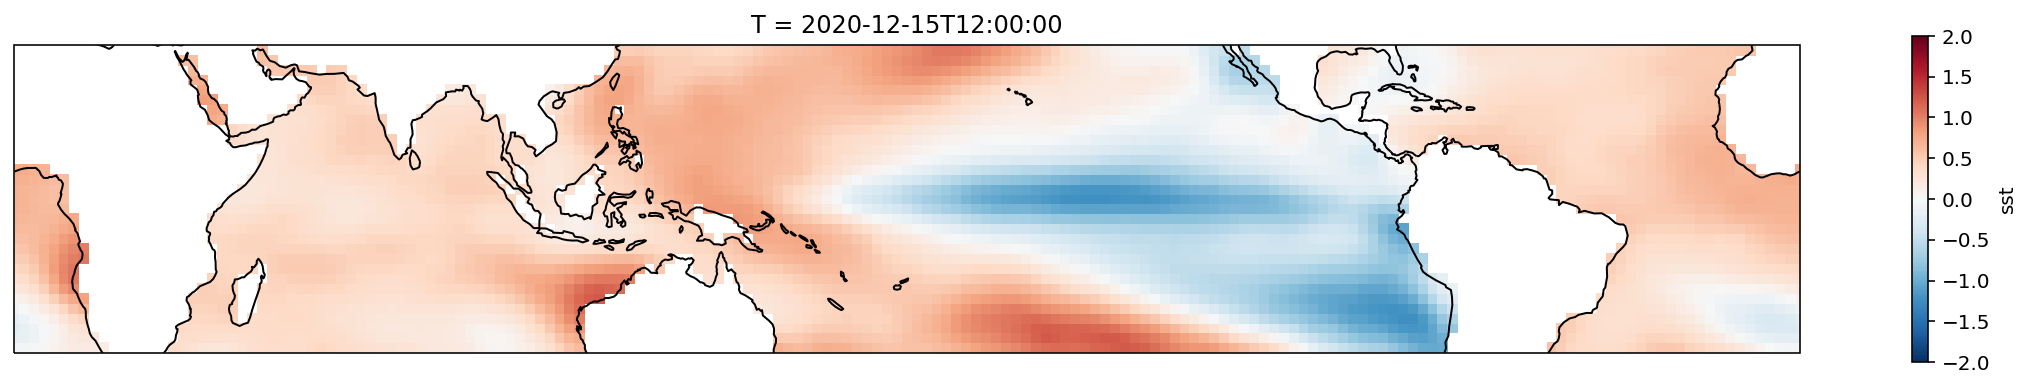

In [33]:
# plot the approximation
proj = ccrs.PlateCarree(central_longitude = 180)
fig, ax = plt.subplots(1, 1, subplot_kw = dict(projection = proj), figsize = (20,3))
ssta_approx.isel(T = -1).plot(ax = ax, vmin = -2, transform = ccrs.PlateCarree());
ax.coastlines();

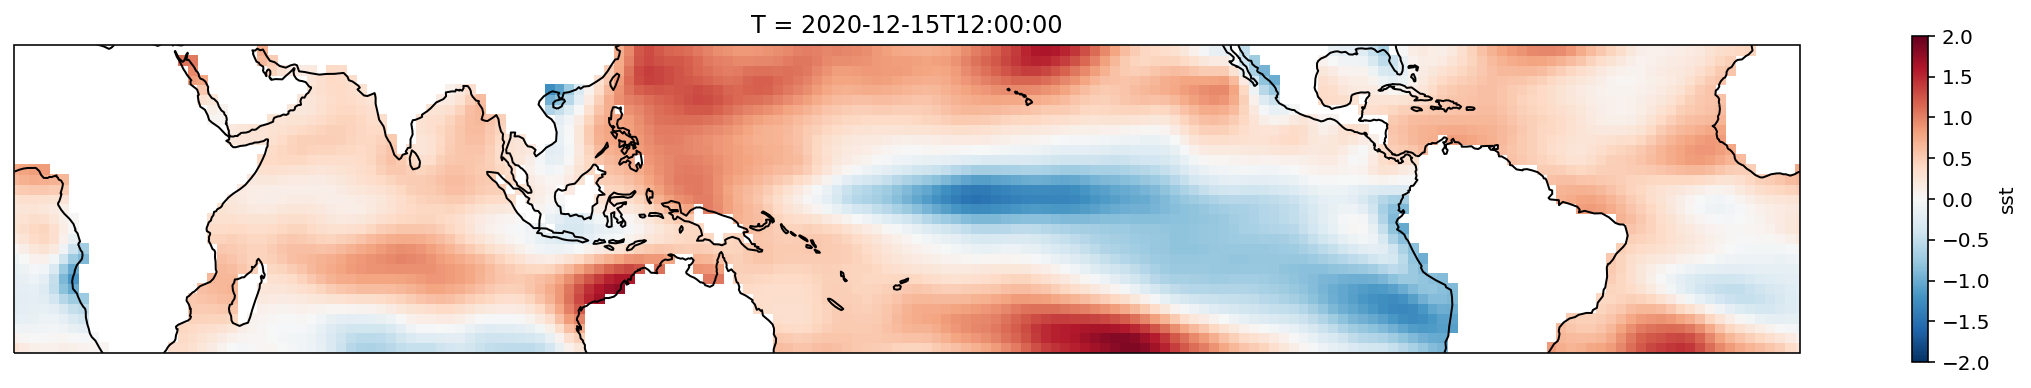

In [34]:
# plot the original
proj = ccrs.PlateCarree(central_longitude = 180)
fig, ax = plt.subplots(1, 1, subplot_kw = dict(projection = proj), figsize = (20,3))
ssta.isel(T = -1).plot(ax = ax, vmin = -2, transform = ccrs.PlateCarree());
ax.coastlines();

## How good is the low-rank approximation?

The low-rank approximation:
$$ A_k = \sum_{i=1}^k \sigma_i u_i v_i^T \,.$$

No approximation:
$$ A = \sum_{i=1}^r \sigma_i u_i v_i^T \,.$$

The error of the approximation?
$$ A - A_k =  \sum_{i= k+1}^r \sigma_i u_i v_i^T$$

How big is the error (with units)?

$$ \| A - A_k \|^2_F = \sum_{i= k+1}^r \sigma_i ^2 $$

How big is the error (without units)?

Fraction of unexplained (by the PCA approximation) variance
$$ \frac{\| A - A_k \|^2_F}{\|A\|_F^2}$$

Fraction of explained (by the PCA approximation) variance
$$ 1 - \frac{\| A - A_k \|^2_F}{\|A\|_F^2} = 1 - \frac{\sum_{i= k+1}^r \sigma_i ^2}{\sum_{i=1}^r \sigma_i ^2} = \frac{\sum_{i= 1}^k \sigma_i ^2}{\sum_{i=1}^r \sigma_i ^2}$$



Ratios of sums of squares = fraction of variance

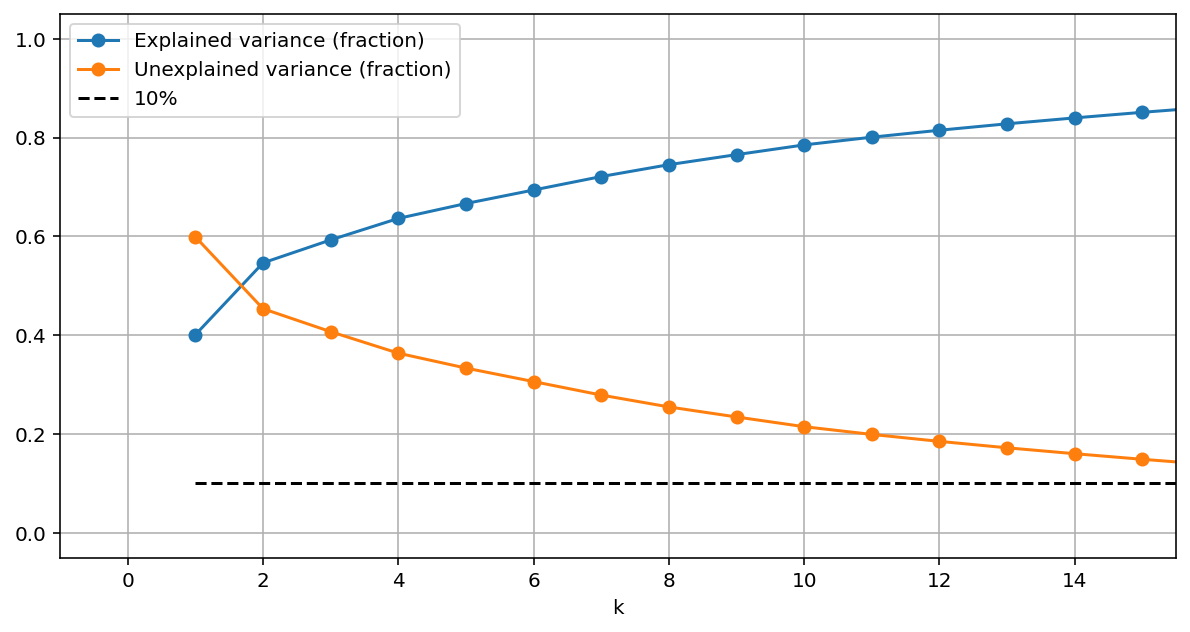

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))

N = nt
Ns = np.arange(1, N + 1)
#plt.plot(Ns, S**2/np.sum(S**2), label ='?');
ax.plot(Ns, np.cumsum(S1**2)/np.sum(S1**2), '-o',  label = 'Explained variance (fraction)')
ax.plot(Ns, 1. - np.cumsum(S1**2)/np.sum(S1**2), '-o', label = 'Unexplained variance (fraction)')
ax.set_xlabel('k')
ax.plot(Ns, np.ones_like(Ns) * 0.1, 'k--', label='10%')
ax.legend();
ax.grid()
ax.set_xlim(-1, 15.5);

## Plotting

How to plot the terms (rank-1 matrices) in the sum? Three plots?

$$\sigma_i\,, u_i\,, v_i^T$$

Two?
$$(\sigma_i u_i)\,, v_i^T$$

Or two?
$$ u_i\,, (\sigma_i v_i^T)$$
Or what?

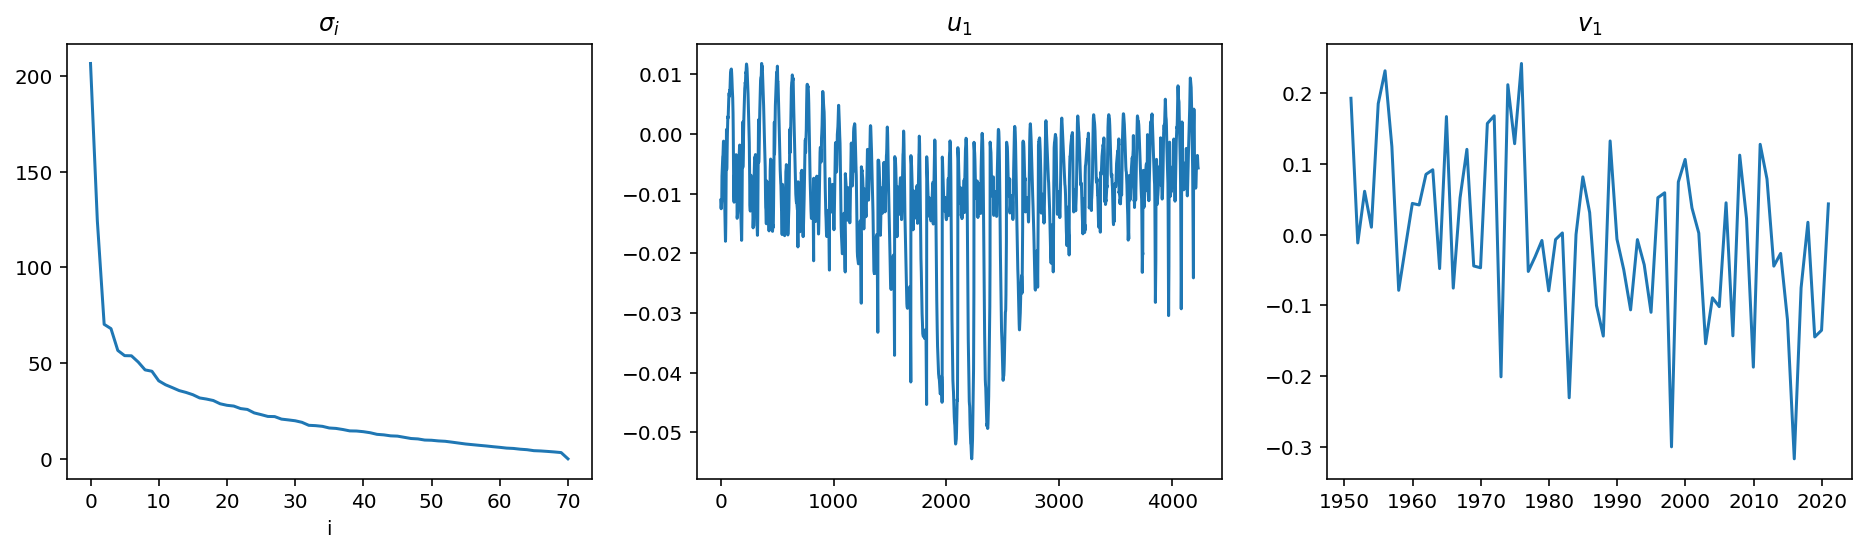

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

ax = axs[0]
ax.plot(S)
ax.set_title(r'$\sigma_i$')
ax.set_xlabel('i')

ax = axs[1]
ax.plot(U[:,0]);
ax.set_title('$u_1$')


ax = axs[2]
ax.plot(sst_ds.T, V[:,0]);
ax.set_title('$v_1$');

What is the reason for the amplitude of the plots?

$v_i$ is a time series. It is handy to normalize it to have unit variance and call it a *principle component*

$$ \text{PC}_i = \sqrt{N - 1} v_i $$
Why does this work?

Then what we take out of $v_i$ we put into the *empirical orthognal function* along with the singular value
$$ \text{EOF}_i = \sigma_i \frac{1}{\sqrt{N - 1}} u_i$$

Then 
$$\text{data} = A = \sum_{i=1}^r \text{EOF}_i \text{PC}_i $$

## Properties of PCs and EOFs
1. PCs are uncorrelated. Why?
    - Because $v_i$'s are orthogonal
2. EOFs are ...
    - orthogonal because $u_i$'s are orthogonal
3. The regression of a PC with the data is ...the EOF,  therefore EOFs are regression patterns
    - $U S V^T v_1$

In [37]:
# Nino 3.4
nino34_str = 'Y/-5/5/RANGEEDGES/X/190/240/RANGEEDGES%5BX/Y%5Daverage/'

n34_url = 'https://iridl.ldeo.columbia.edu/' + dl_loc + time_str + nino34_str + 'zlev/removeGRID/' + time_fix + 'dods'

n34_ds = xr.open_dataset(n34_url)
n34a = n34_ds.sst.groupby('T.month') - n34_ds.sst.groupby('T.month').mean('T')

## Plotting EOFs and PCs

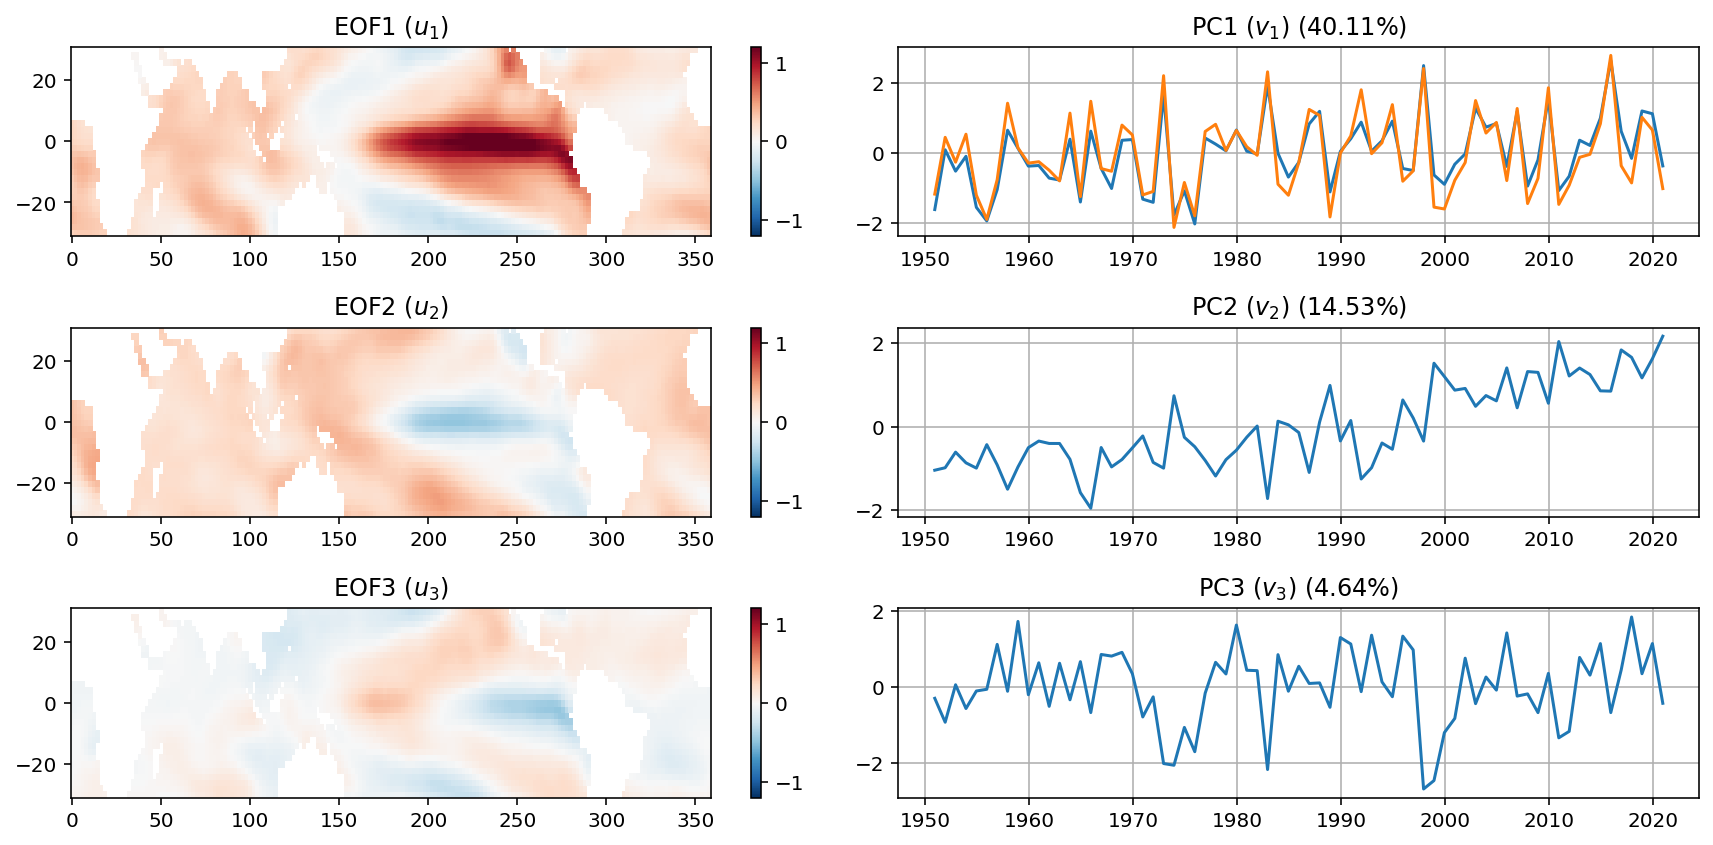

In [38]:
X = sst_ds.X
Y = sst_ds.Y
T = sst_ds.T

# k = number of EOFs to look at
k = 3

# EOFs are for plotting and have the dimensions original maps (with missing values)
EOFs = np.zeros((ny * nx, k)) + np.nan
EOFs[goodXY,:] = U[:, 0:k] / np.sqrt(nt-1) @ np.diag(S[0:k])
EOFs = EOFs.reshape([ny, nx, k])

PCs = np.zeros((nt, k)) + np.nan
PCs[:,:] = V[:, 0:k] * np.sqrt(nt - 1)

VarExp = S**2/np.sum(S**2)

fig, axes = plt.subplots(k, 2, figsize=(12, 2*k))
for ii in range(0,k):
    g = axes[ii,0].pcolormesh(X, Y, -EOFs[:,:,ii], cmap='RdBu_r', vmin=-1.2, vmax=1.2, shading='auto')
    plt.colorbar(g,ax=axes[ii,0])
    axes[ii,1].plot(T, -PCs[:,ii])
    axes[ii,1].set_title('PC{0} ($v_{0}$) ({1:2.2f}%)'.format(ii+1, 100*VarExp[ii]))
    axes[ii,1].grid()
    axes[ii,0].set_title('EOF{0} ($u_{0}$)'.format(ii+1))
plt.tight_layout()
fig.set_facecolor("white")

axes[0, 1].plot(T, n34a);

Final exam question: Why is El Niño called El Niño?

# Total least squares 
vs. least squares

## Solution by SVD

Least squares finds the $\hat{x}$ that minimizes

$$\| A \hat{x} - b\|^2 $$

The idea is that the quantity $b$ *should* be a linear combination of the columns of $A$ but the values of $b$ that we have contain measurement errors. That is, for some unknown $x_{true}$, $b_{true} = A x_{true}$, and what we measure is $b = b_{true} + error$. Given our measurement $b$, we can compute our least-squares estimate $\hat{x}$.

In the context of line fitting, minimizing $\| A \hat{x} - b\|^2 $ means minimizing the *vertical* distance between the fit line and the data ($b$).

Total least squares minimizes the total (perpendictular) distance between the line and the data ($b$). The squared total distance is the sum of the squared vertical distance plus the squared horizontal distance.

$$ total ~ distance = \| \hat{A} \hat{x} - b\|^2 + \|\hat{A}  - A\|^2_F $$ 

(Insert picture for line fit case)

What does this have to do with $A$ being measured with error?

Equivalently, 

$$ \text{total distance}  = \| [\hat{A} - A, \hat{A} \hat{x} - b] \|^2_F = \| W - Z \|$$ 

where $W = [\hat{A}, \hat{A} \hat{x}]$ and $Z = [A, b]$. $Z$ contains quantities that we measure, and $W$ contains quantities that are unknown and must be estimated.

Can we solve the TLS problem by choosing $W = Z$? 

No. Assuming that the $n$ columns of $A$ are linearly independent, and that $Ax = b$ has no solution, the rank of $Z$ is $n+1$. On the other hand, the rank of $W$ is at most $n$ because its last column is a linear combination of its first $n$ columns. 

The best choice for $W$ is the rank-$n$ approximation of $Z$, which can be computed using the SVD $Z = U \Sigma V^T$ as

$$ W = \sum_{i=1}^n \sigma_i u_i v_i^T $$

Fine, but what is the TLS solution $\hat{x}$?

By construction $v_{n+1}$ is in the null space of $W$ and $W v_{n+1} = 0$ because perpendictular to all the other $v$'s.

Denote the $n$-th component of $v_{n+1}$ by $\alpha$ and assume $\alpha \neq 0$. Then $\hat{x}$ is related to $v_{n+1}$ by

$$ v_{n+1} = \alpha \begin{bmatrix} \hat{x} \\ -1 \end{bmatrix}, $$

which is directly verified by

$$ W v_{n+1} = [\hat{A}, \hat{A} \hat{x} ] \begin{bmatrix} \hat{x} \\ -1 \end{bmatrix} =
\hat{A} \hat{x} - \hat{A} \hat{x}  = 0.$$

## Data

(APMA 4300 example)

We start by constructing a random data set that approximates a straight line but has random errors in *both* x and y coordinates

In [50]:
# npoints uniformly randomly distributed points in the interval [0,3]
npnts = 100
xtrue = np.random.uniform(0.,3.,npnts)
# set y = mx + b plus random noise of size err
slope = 2
intercept = 1.
err = .5

# the TRUTH
ytrue = slope * xtrue + intercept 

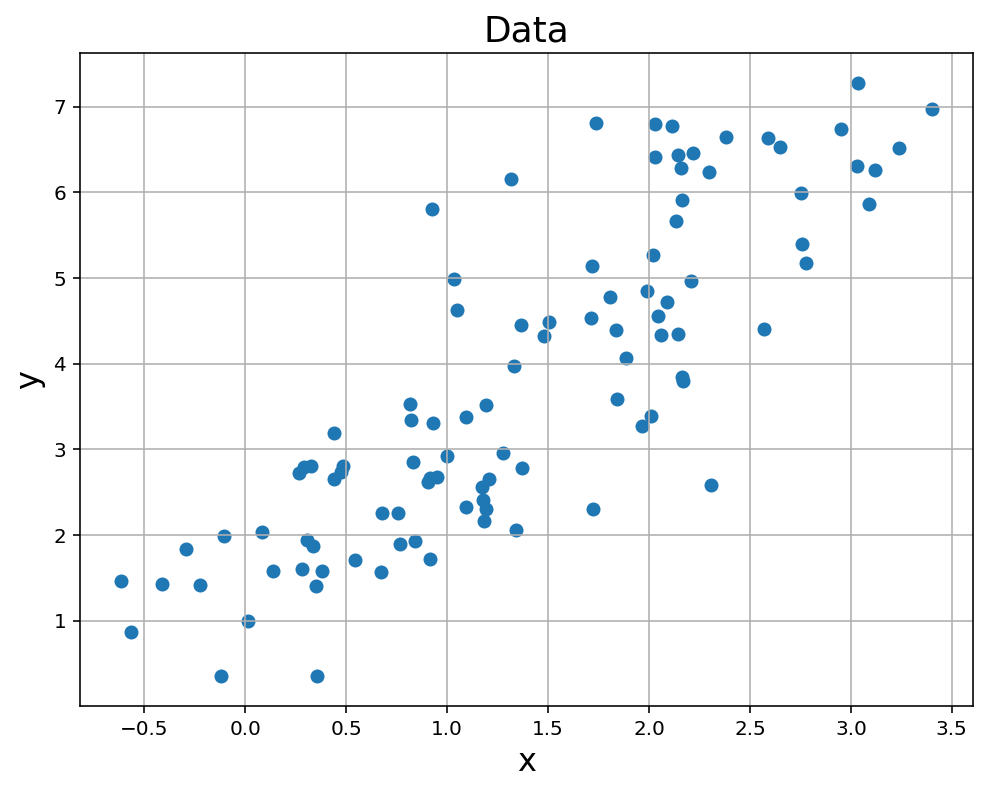

In [51]:
# add some random noise to ytruth
y = ytrue + np.random.normal(scale=err, size=npnts)

# add some random noise to xtruth
x = xtrue + np.random.normal(scale=err, size=npnts)

# And plot out the data
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1,1,1)
axes.scatter(x,y)
axes.set_xlabel('x',fontsize=16)
axes.set_ylabel('y', fontsize=16)
axes.set_title('Data', fontsize=18)
axes.grid()
plt.show()

## Classical Least Squares:  

We first calculate the best fit straight line assuming all the error is in the $y$ variable using the a $QR$ decomposition of the Vandermonde matrix $A = \begin{bmatrix} 1 & \mathbf{x}\\\end{bmatrix}$

In [52]:
# Vandermonde matrix
A = np.array([ np.ones(x.shape), x]).T

# solve  Ac = y using the QR decomposition via scipy
c_ls,res,rank,s = np.linalg.lstsq(A,y, rcond=None)
print('Best fit Linear Least Squares:')
print('    slope={}'.format(c_ls[1]))
print('    intercept={}'.format(c_ls[0]))

Best fit Linear Least Squares:
    slope=1.6035575833060114
    intercept=1.5655142472808616


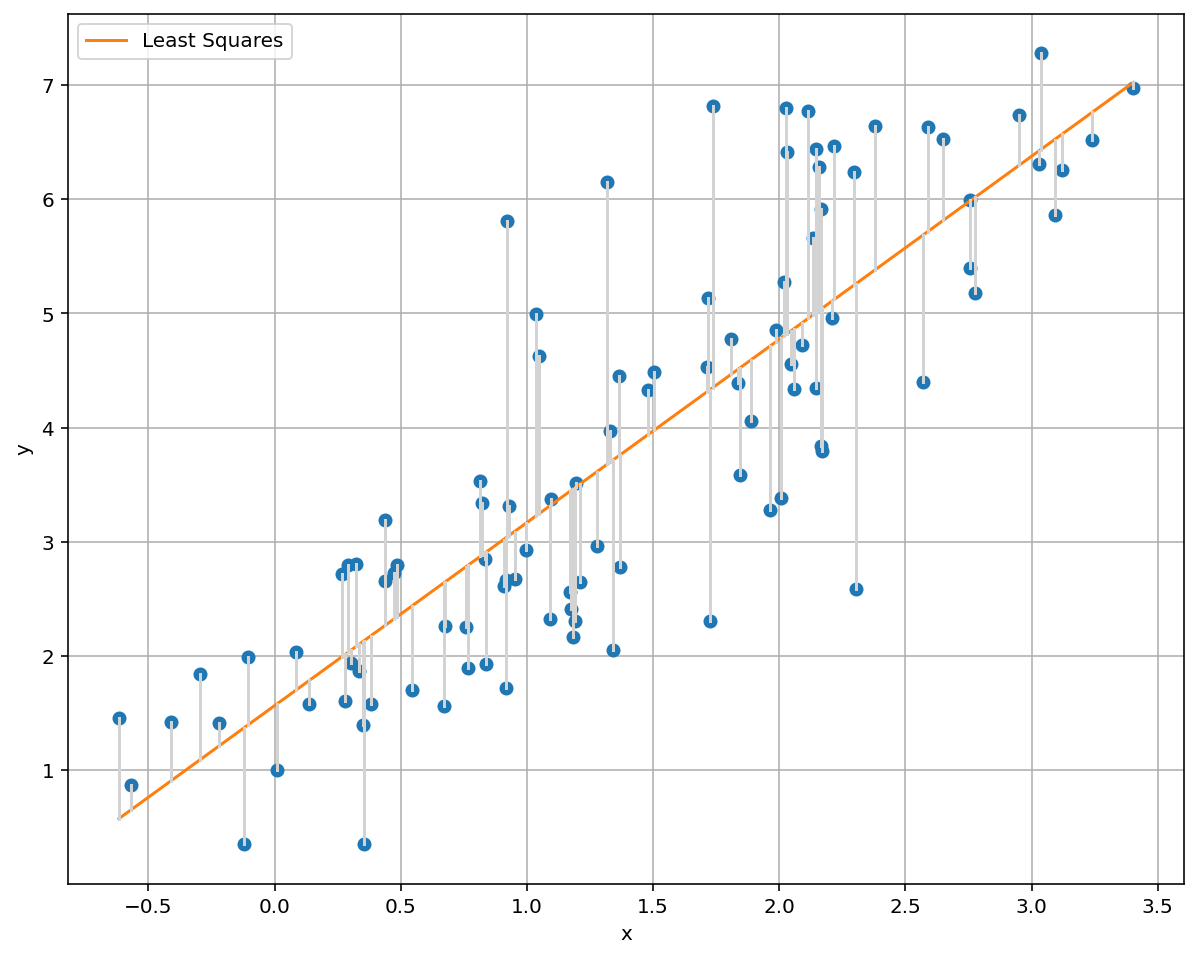

In [53]:
# dummy variables 
t_ls = np.linspace(x.min(), x.max())

# And plot out the data
fig  = plt.figure(figsize=(10,8))
axes = fig.add_subplot(1,1,1)
axes.plot(x, y, 'o')
axes.set_xlabel('x')
axes.set_ylabel('y')
# plot the least squares solution
axes.plot(t_ls,c_ls[0]+t_ls*c_ls[1], label='Least Squares')
axes.legend()
axes.grid()

for ii in range(npnts):
    plt.plot(x[ii]*np.array((1, 1)), np.array((y[ii], c_ls[0] + x[ii]*c_ls[1])), color='lightgray')
plt.show()

## What's wrong with classical least squares? It's biased!

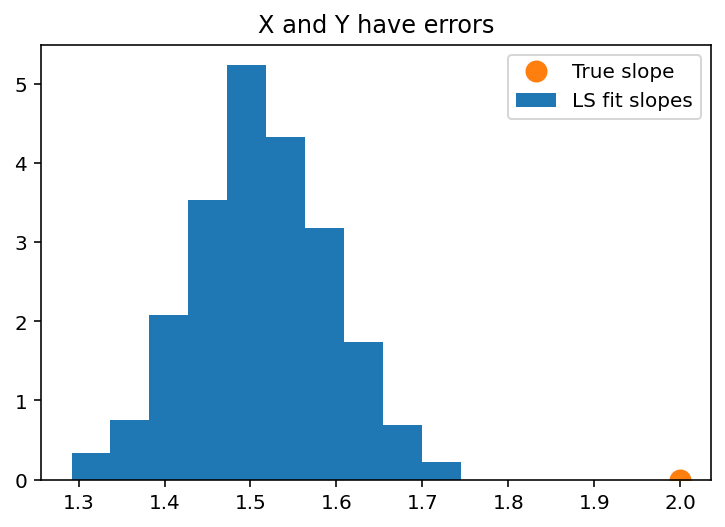

In [54]:
ytrue = slope * xtrue + intercept 
err = 0.5

mcmax = 1000
slope_ls = np.empty(mcmax)
for ii in range(mcmax):
    # add some random noise to ytrue
    y = ytrue + np.random.normal(scale=err, size=npnts)

    # add some random noise to xtrue
    x = xtrue + np.random.normal(scale=err, size=npnts)

    # Vandermonde matrix
    A = np.array([ np.ones(x.shape), x]).T

    # solve  Ac = y using the QR decomposition via scipy
    c_ls,res,rank,s = np.linalg.lstsq(A,y, rcond=None)
    slope_ls[ii] = c_ls[1]
    
plt.hist(slope_ls, density=True, label='LS fit slopes')
plt.plot(slope, 0, 'o', ms=10, label='True slope')
plt.legend()
plt.title('X and Y have errors')
plt.show()

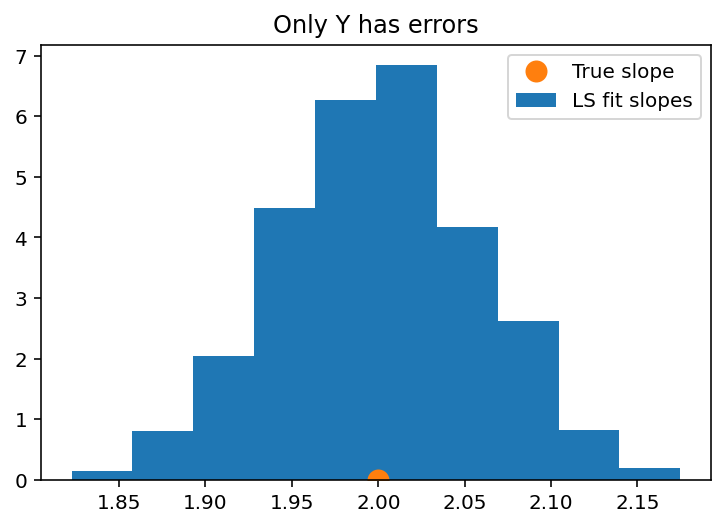

In [55]:
ytrue = slope * xtrue + intercept 
err = 0.5

mcmax = 1000
slope_mc = np.empty(mcmax)
for ii in range(mcmax):
    # add some random noise to ytrue
    y = ytrue + np.random.normal(scale=err, size=npnts)

    # add some random noise to xtrue
    x = xtrue #+ np.random.normal(scale=err, size=npnts)

    # Vandermonde matrix
    A = np.array([ np.ones(x.shape), x]).T

    # solve  Ac = y using the QR decomposition via scipy
    c_ls,res,rank,s = np.linalg.lstsq(A,y, rcond=None)
    slope_mc[ii] = c_ls[1]
    
plt.hist(slope_mc, density=True, label='LS fit slopes')
plt.plot(slope, 0, 'o', ms=10, label='True slope')
plt.legend()
plt.title('Only Y has errors')
plt.show()

Note that in both cases the estimate of the slope has uncertainty because of the errors. (Repeating the "measurements" gives a different answer). 

You learn in a stat class how to compute this uncertainty for case where only y has errors (Gaussian distributed).

## Total Least-Squares 
(a recipe from APMA 4300)

* form a matrix $M$ whose rows are the de-meaned data (BECAUSE the constant term is NOT measured with error)
* find the SVD of $M = U\Sigma V^T$, 
* set $\mathbf{u} = \mathbf{v}_2$ 
* and in 2-D,  the best fit line is parallel to $\mathbf{v}_1$ and goes through the mean of the data

In [56]:
# Prepare the data matrix
X = np.array([ x , y]).T
print('Shape of data Matrix: {}'.format(X.shape))

Shape of data Matrix: (100, 2)


In [57]:
# and remove the mean
X_mean = np.mean(X,0)
print('Mean of data matrix={}'.format(X_mean))
M = X - X_mean

Mean of data matrix=[1.39714728 3.80524683]


In [58]:
# now calculate the SVD of the de-meaned data matrix
U,S,VT = np.linalg.svd(M,full_matrices=False)
V = VT.T
print('Singular values = {}'.format(S))
print('First Right singular vector V_1= {}'.format(V[:,0]))

Singular values = [19.98980519  2.02611646]
First Right singular vector V_1= [0.42711969 0.9041951 ]


Now plot and compare the two solutions


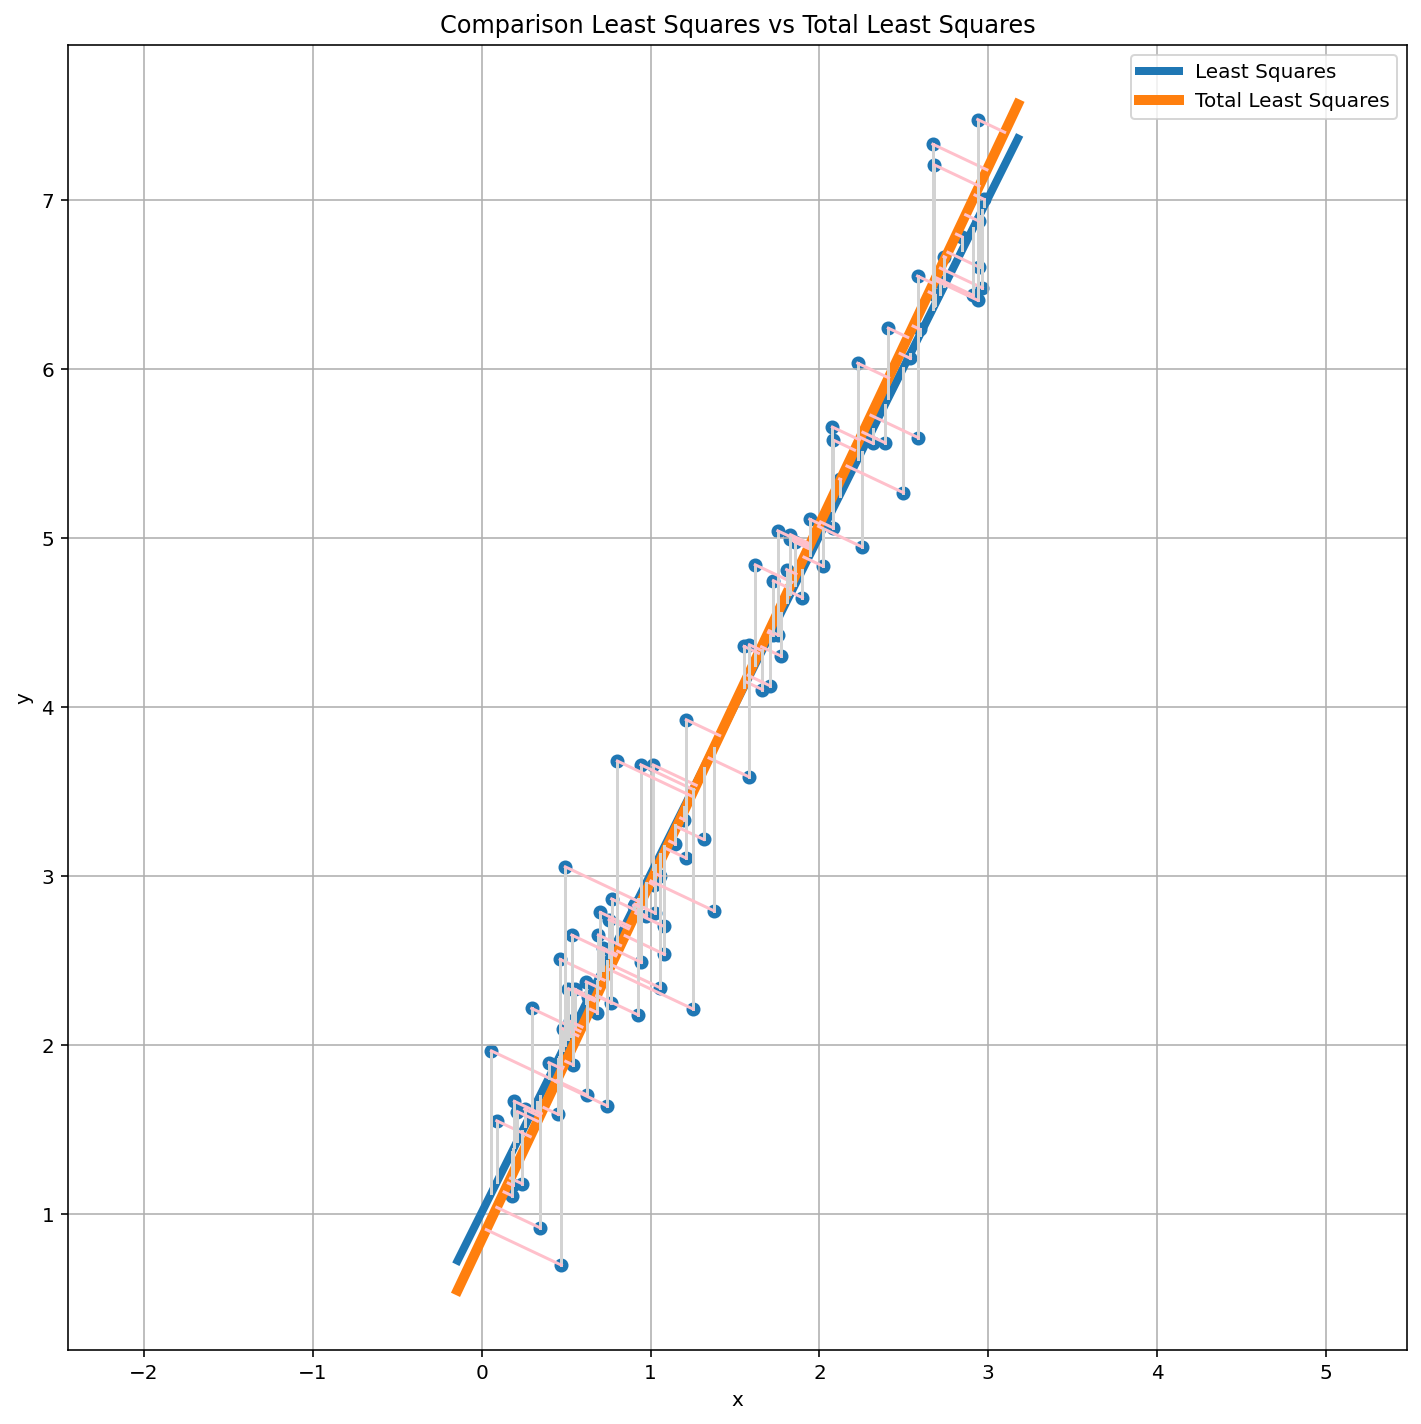

In [59]:
# dummy variables 
t_ls = np.linspace(x.min() - 0.2, x.max() + 0.2)
#t_svd =  2*(t_ls - np.mean(t_ls))

# make figure
plt.figure(figsize=(12, 12))
# plot data
plt.scatter(x,y)
# plot the least squares solution
plt.plot(t_ls,c_ls[0]+t_ls*c_ls[1], linewidth=4, label='Least Squares')

# plot the total least Squares solution
# plot the mean
# plt.plot(X_mean[0],X_mean[1],'go', markersize=12, label='X_mean')
# calculate a line through the mean with the first principal component as a basis
#L_tls = X_mean + np.outer(t_svd,V[:,0])
#plt.plot(L_tls[:,0],L_tls[:,1],'c-',label='Total Least Squares')
W = S[0] * np.outer(U[:, 0], V[:, 0]) 
x_tls = W[:, 0]
tls_slope = -V[0, -1]/V[1, -1]
plt.plot(t_ls,  tls_slope * (t_ls - x.mean()) + y.mean(), linewidth=5, label='Total Least Squares')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Comparison Least Squares vs Total Least Squares')
plt.legend(loc='best')
plt.grid()

for ii in range(npnts):
    plt.plot(x[ii]*np.array((1, 1)), np.array((y[ii], c_ls[0] + x[ii]*c_ls[1])), color='lightgray')
    tls_line_x = x_tls[ii] + x.mean() 
    tls_line_y = tls_slope * x_tls[ii] + y.mean() 

    plt.plot(np.array((x[ii], tls_line_x)), np.array((y[ii], tls_line_y)), color='pink')

plt.axis('equal')
plt.show()

Underwhelming

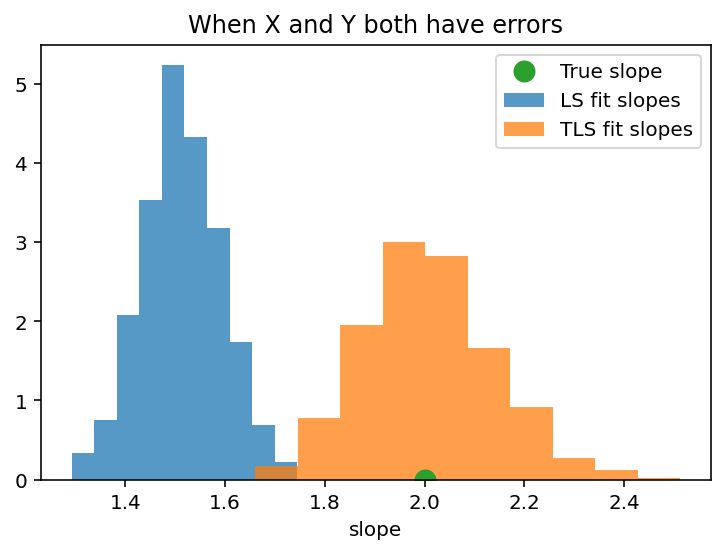

In [60]:
ytrue = slope * xtrue + intercept 
err = 0.5

mcmax = 1000
slope_tls = np.empty(mcmax)
for ii in range(mcmax):
    # add some random noise to ytrue
    y = ytrue + np.random.normal(scale=err, size=npnts)

    # add some random noise to xtrue
    x = xtrue + np.random.normal(scale=err, size=npnts)

    # Prepare the data matrix
    X = np.array([ x , y]).T
    # and remove the mean
    X_mean = np.mean(X,0)
    M = X - X_mean
    # now calculate the SVD of the de-meaned data matrix
    U,S,VT = np.linalg.svd(M,full_matrices=False)
    V = VT.T
    
    slope_tls[ii] = -V[0, -1]/V[1, -1]
    
plt.hist(slope_ls, density=True, label='LS fit slopes', alpha=0.75)
plt.hist(slope_tls, density=True, label='TLS fit slopes', alpha=0.75)
plt.plot(slope, 0, 'o', ms=10, label='True slope')
plt.xlabel('slope')
plt.legend()
plt.title('When X and Y both have errors')
plt.show()

LS is biased and underestimates the uncertainty.